<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/PyTorch%E6%9C%AC4_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 4.7 推論の実施
本ファイルでは、学習させたOpenPoseで姿勢推定を行います。

# 学習目標
* OpenPoseの学習済みモデルをロードできるようになる
* OpenPoseの推論を実装できるようになる  
[写経元](https://github.com/YutaroOgawa/pytorch_advanced/blob/master/4_pose_estimation/4-7_OpenPose_inference.ipynb)

In [0]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [2]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 441, done.
remote: Total 441 (delta 0), reused 0 (delta 0), pack-reused 441
Receiving objects: 100% (441/441), 14.62 MiB | 12.79 MiB/s, done.
Resolving deltas: 100% (231/231), done.


In [3]:
%cd pytorch_advanced/
%cd 4_pose_estimation

/content/pytorch_advanced
/content/pytorch_advanced/4_pose_estimation


In [0]:
import os
import urllib.request
import zipfile
import tarfile

In [0]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [6]:
def gdrive_dl(filename):
  upload_filename = filename

  file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')

  # ファイル ID を取得します。
  file_id = None
  for file in file_list:
    if file.get('name') == upload_filename:
      file_id = file.get('id')
      break

  if file_id is None:
    # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
    print(upload_filename + ' が見つかりません.')
  else:
    # colab 環境へファイルをアップロードします。
    with open(upload_filename, 'wb') as f:
      request = drive_service.files().get_media(fileId=file_id)
      media = googleapiclient.http.MediaIoBaseDownload(f, request)

      done = False
      while not done:
        progress_status, done = media.next_chunk()
        print(100*progress_status.progress(), end="")
        print("%完了")

    print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')
    
gdrive_dl("pose_model_scratch.pth")

50.103341341944294%完了
100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


In [0]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [8]:
from utils.openpose_net import OpenPoseNet

# 学習済みモデルと本章のモデルでネットワークの層の名前が違うので、対応させてロードする
# モデルの定義
net = OpenPoseNet()

# 学習済みパラメータをロードする
net_weights = torch.load(
    'pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})#./weights/pose_model_scratch.pth
keys = list(net_weights.keys())

weights_load = {}

# ロードした内容を、本書で構築したモデルの
# パラメータ名net.state_dict().keys()にコピーする
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

# コピーした内容をモデルに与える
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('ネットワーク設定完了：学習済みの重みをロードしました')

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 71.9MB/s]


ネットワーク設定完了：学習済みの重みをロードしました


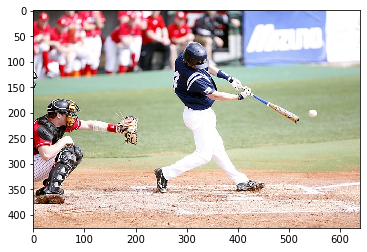

In [9]:
# 草野球の画像を読み込み、前処理します

test_image = './data/hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  # B,G,Rの順番

# BGRをRGBにして表示
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 画像の前処理
img = img.astype(np.float32) / 255.

# 色情報の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# （高さ、幅、色）→（色、高さ、幅）
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をTensorに
img = torch.from_numpy(img)

# ミニバッチ化：torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

In [0]:
# OpenPoseでheatmapsとPAFsを求めます
net.eval()
predicted_outputs, _ = net(x)

# 画像をテンソルからNumPyに変化し、サイズを戻します
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

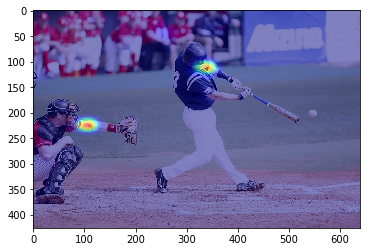

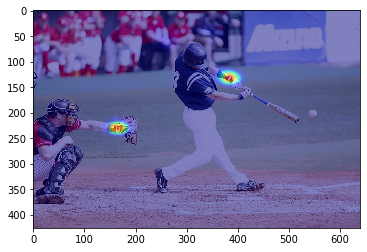

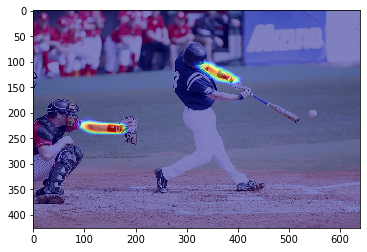

In [11]:
# 左肘と左手首のheatmap、そして左肘と左手首をつなぐPAFのxベクトルを可視化する
# 左肘
heat_map = heatmaps[:, :, 6]  # 6は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 左手首
heat_map = heatmaps[:, :, 7]  # 7は左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 左肘と左手首をつなぐPAFのxベクトル
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [0]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

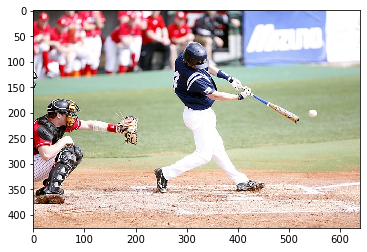

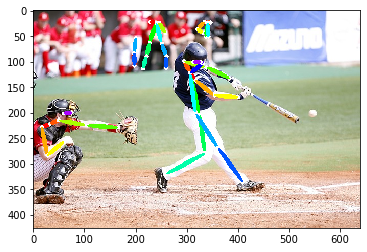

In [13]:
# 結果を描画
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()